In [5]:
import json
import numpy as np
import pandas as pd
import plotly.express as px
import mlxtend as mlx
from tqdm.notebook import tqdm, trange
from itertools import chain

In [6]:
def read_json(path):
    file = open(path,'r+', encoding='utf-8')
    data = {}
    for line in file.readlines():
        try: 
            dic = json.loads(line)
            if dic['author'] in data.keys():
                if dic['subreddit'] in data[dic['author']].keys():
                    data[dic['author']][dic['subreddit']] +=1
                else:
                    data[dic['author']][dic['subreddit']] =1
            else:
                data[dic['author']] = {}
                data[dic['author']][dic['subreddit']] = 1
        except json.JSONDecodeError:
            continue
    return data

In [7]:
def jsonKeys2int(x):
    if isinstance(x, dict):
            return {int(k):v for k,v in x.items()}
    return x

In [34]:
data = json.load(open('reddit_scrapper/data/scrapped_data2.json','r+'))
subreddit_names_list = json.load(open('reddit_scrapper/data/list_of_unique_subreddits2.json','r+'))
# subreddit_index = json.load(open('subreddit_index.json','r+'))
# index_subreddit = json.load(open('index_subreddit.json','r+'),object_hook=jsonKeys2int)

In [35]:
subreddit_index = dict(zip(subreddit_names_list,range(len(subreddit_names_list))))
index_subreddit =  dict(zip(range(len(subreddit_names_list)),subreddit_names_list))

In [36]:
def create_matrix(data,matrix_width,subreddit_index):
    """ Creates matrix filled with zeros and iterates over it filling the cells based on 
        the subreddit-index dictionary"""
    matrix = np.zeros(shape=(len(data),matrix_width))
    for idx,redditor in enumerate(data.values()):
        for key,value in redditor.items():
            matrix[idx,subreddit_index[key]] = value
    return matrix

In [37]:
def update_dictionaries(new_redditors,subreddit_index,index_subreddit,subreddit_names_list):
    """ Updating index-subreddit,subreddit-index dictionaries and subreddit_names_list according to the
        new_redditors- new incoming data"""
    for redditor in new_redditors.values():
        for i in redditor.keys():
            if i not in subreddit_names_list:
                subreddit_index[i] = len(subreddit_index)
                index_subreddit[len(index_subreddit)] = i
                subreddit_names_list.append(i)
    return subreddit_index,index_subreddit,subreddit_names_list

In [38]:
def resize_matrix_width(matrix,subreddit_index):
    """ Updating the width of the main matrix to match it with the incoming data"""
    if matrix.shape[1] != len(subreddit_index):
        extension = np.zeros((matrix.shape[0],len(subreddit_index)-matrix.shape[1]))
        matrix = np.hstack((matrix, extension))
    return matrix 

In [39]:
def update(matrix,new_redditors,subreddit_index,index_subreddit,subreddit_names_list):
    """Function that manages new incoming data and combines it with the main matrix"""
    subreddit_index,index_subreddit,subreddit_names_list = \
    update_dictionaries(new_redditors,subreddit_index,index_subreddit,subreddit_names_list)
    matrix = resize_matrix_width(matrix,subreddit_index)
    recent_data = create_matrix(new_redditors,matrix.shape[1],subreddit_index)
    matrix = np.vstack((matrix, recent_data))
    return matrix,subreddit_index,index_subreddit,subreddit_names_list

### Create matrix

Remove rows and columns where all cells contains integer less or equal to 5. E.g. when a redditor comments less than threshold (6) times in a given reddit we consider an inconsiderable input so we floor it to zero. If a given redditor has commented less than the threshold in all the reddits (0/False vector) we remove him from the data. Same applies to reddit sites.

In [40]:
matrix = create_matrix(data,len(subreddit_names_list),subreddit_index)

In [91]:
mask = np.where(matrix>5,True,False)
rows = ~np.all(mask==False,axis=1)
columns = ~np.all(mask==False,axis=0)
data = matrix[np.ix_(rows,columns)]
df = pd.DataFrame(data,columns=np.squeeze(np.argwhere(x)))
df.rename(columns=index_subreddit,inplace=True)

In [98]:
df_bool = df.astype(bool).astype(int)

### Clustering

In [118]:
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import prince
import seaborn as sns
import plotly.express as px

In [129]:
data_clustering = df ##Choose boolean data or data with the frequency of posting in a given reddit
k = 1000 ##  Choose number of most popular reddits
n_components = 2 ## Choose number of dimensions to project the data onto

In [131]:
most_popular_reddits = data_clustering.sum(axis=0).sort_values(ascending=False)[:k].index
X = data_clustering.loc[:,most_popular_reddits]
tsne =  TSNE(n_components=n_components,n_jobs=-1,random_state=69)
X = tsne.fit_transform(X)

In [132]:
clustering = DBSCAN(eps=4, min_samples=30,n_jobs=-1).fit(X)

In [133]:
if n_components == 2:
    X = pd.DataFrame(X,columns=['component1','component2'])
    X['clustering'] = clustering.labels_
    X['clustering'] = X['clustering'].astype(str)
    print(f"Number of clusters {pd.unique(X['clustering']).shape[0]}")
    fig = px.scatter(X,x="component1", y="component2", color="clustering")
    fig.show()

Number of clusters 24


multiplied by the function of the occurences/frequency

For n_clusters = 100 The average silhouette_score is : 0.18602483709576384


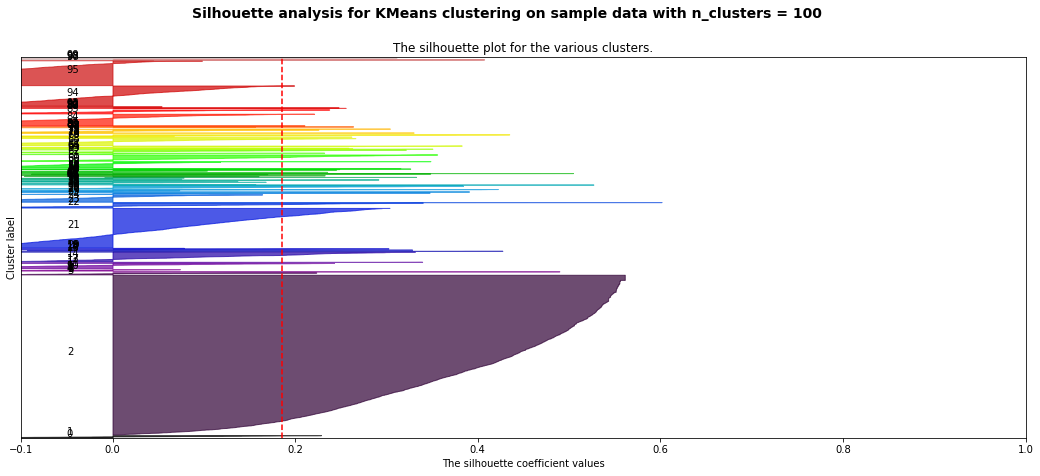

In [69]:
range_n_clusters = [100]
for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

In [13]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [14]:
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, 
                  metric='confidence', 
                  min_threshold=0.7)

antecedents              consequents  \
0                                    (self)              (AskReddit)   
1                           (todayilearned)              (AskReddit)   
2                         (DoesAnybodyElse)              (AskReddit)   
3                           (entertainment)             (reddit.com)   
4                                 (offbeat)             (reddit.com)   
..                                      ...                      ...   
406  (reddit.com, funny, politics, science)              (pics, WTF)   
407          (pics, science, politics, WTF)      (reddit.com, funny)   
408        (funny, pics, science, politics)        (reddit.com, WTF)   
409         (funny, science, politics, WTF)       (reddit.com, pics)   
410              (funny, science, politics)  (reddit.com, pics, WTF)   

     antecedent support  consequent support   support  confidence       lift  \
0              0.015186            0.480390  0.011720    0.771772   1.606551   
1              0.013818            0.480390  0.010489    0.759076   1.580123   
2              0.046242            0.480390  0.034476    0.745562   1.551992   
3              0.015232            0.287121  0.010762    0.706587   2.460933   
4              0.015460            0.287121  0.011264    0.728614   2.537649   
..                  ...                 ...       ...         ...        ...   
406            0.013088            0.066627  0.010078    0.770035  11.557374   
407            0.014274            0.054633  0.010078    0.706070  12.923797   
408            0.012222            0.085462  0.010078    0.824627   9.649102   
409            0.011583            0.091800  0.010078    0.870079   9.477937   
410            0.013955            0.052900  0.010078    0.722222  13.652490   

     leverage  conviction  
0    0.004425    2.276711  
1    0.003851    2.156736  
2    0.012262    2.042187  
3    0.006389    2.429606  
4    0.006825    2.626802  
..        ...         ...  
406  0.009206    4.058758  
407  0.009299    3.216302  
408  0.009034    5.214815  
409  0.009015    6.990385  
410  0.009340    3.409559  

[411 rows x 9 columns]

In [ ]:
rules.to_json("data/arules.json")